In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP
from preprocess_data import recode_variables, split_train_cal_test

In [3]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
df = pd.read_csv(f_path, na_values="None")
df = df.replace(to_replace=' ', value=np.nan)
df = recode_variables(df)

In [4]:
df.dropna(inplace=True)

ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']

X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]

outcome = 'Waist'
y = df[[outcome]]
y = y[outcome].astype(float)

In [5]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.1
reg = CP(X_train, X_cal, y_train, y_cal)
reg.train(alpha=alpha)
scores = reg.calculate_scores()
qhat = reg.calc_qhat(alpha=alpha)

Fitting lower quantile (0.05)
Fitting upper quantile (0.95)
Fitting median quantile (0.5)
At alpha=0.1, qhat = -0.17743735437112207


In [6]:
test_pred_df = reg.predict_quantiles(X_test, y_test = y_test)

In [7]:
test_no_cal_df = reg.conformalize_CIs(test_pred_df, qhat=0)
test_cp_df = reg.conformalize_CIs(test_pred_df)

Conformalizing with qhat=0
Conformalizing with qhat=-0.17743735437112207


Predicted CIs

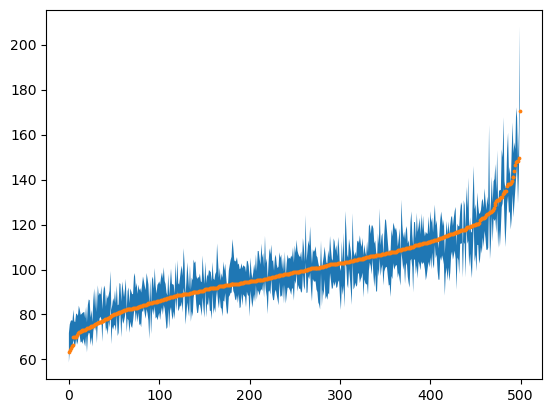

In [11]:
sample_df = test_cp_df.copy()
sample_df = sample_df.sample(n = 500)
sample_df = sample_df.sort_values(by=['y_true'])
sample_df = sample_df.reset_index()
import matplotlib.pyplot as plt

plt.fill_between(sample_df.index, sample_df['y_lower'], sample_df['y_upper'])
plt.scatter(sample_df.index, sample_df['y_true'], s=3)

Coverage by difference size

In [14]:
test_cp_df_tmp = test_cp_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["diff"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

for split_df in dfs:
    min_max = (split_df['diff'].iloc[0], split_df['diff'].iloc[-1])
    coverage = reg.calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage}")

Range 7.4553401758287094 to 13.122176103096706: 0.88
Range 13.122265219770796 to 14.661962205621634: 0.8945454545454545
Range 14.662583044167363 to 16.354273206767772: 0.9148051948051948
Range 16.35674360529198 to 19.003180151321843: 0.9085714285714286
Range 19.003462761156484 to 48.045769340708944: 0.8970893970893971


/Users/carlharris/anaconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Coverage by true WC

In [15]:
test_cp_df_tmp = test_cp_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["y_true"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

for split_df in dfs:
    min_max = (split_df['y_true'].iloc[0], split_df['y_true'].iloc[-1])
    coverage = reg.calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage} (avg diff = {np.mean(split_df['diff'])})")

Range 57.9 to 85.4: 0.854025974025974 (avg diff = 13.26168062954497)
Range 85.4 to 94.1: 0.932987012987013 (avg diff = 14.57175505485725)
Range 94.1 to 102.0: 0.9283116883116883 (avg diff = 15.552022045683785)
Range 102.0 to 112.3: 0.9127272727272727 (avg diff = 17.039658647199794)
Range 112.3 to 176.7: 0.8669438669438669 (avg diff = 20.52961972198753)


/Users/carlharris/anaconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Coverage by ethnicity

In [16]:
for col in eth_dummies:
    y_col = test_cp_df[X_test[col] == 1]
    coverage = reg.calc_coverage(y_col)
    print(f"{col}: {coverage}")

Eth_Mex_Am: 0.9141445336627548
Eth_Oth_Hisp: 0.8955067920585162
Eth_Nonhisp_White: 0.9028106120304702
Eth_Nonhisp_Black: 0.8899082568807339
Eth_Other: 0.884071630537229


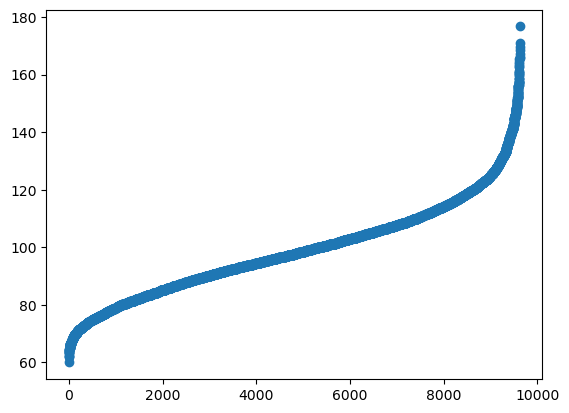

In [27]:
cov_no_cal = reg.calc_coverage(test_no_cal_df, y_test)
cov = reg.calc_coverage(test_cp_df, y_test)
print(cov_no_cal, cov)

In [65]:
from sklearn.metrics import r2_score

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_lower'])
print(f"R2: {r2}")

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_upper'])
print(f"R2: {r2}")

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_median'])
print(f"R2: {r2}")

Range: 58.7 to 83.0: 0.8733264675592173, 13.927531400619156
Range: 83.1 to 92.1: 0.945417095777549, 16.13029965325011
Range: 92.1 to 100.5: 0.9392378990731205, 18.02001779620247
Range: 100.5 to 111.9: 0.913491246138002, 20.225221798261146
Range: 111.9 to 169.5: 0.8855670103092783, 24.789767131625783


/Users/carlharris/anaconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


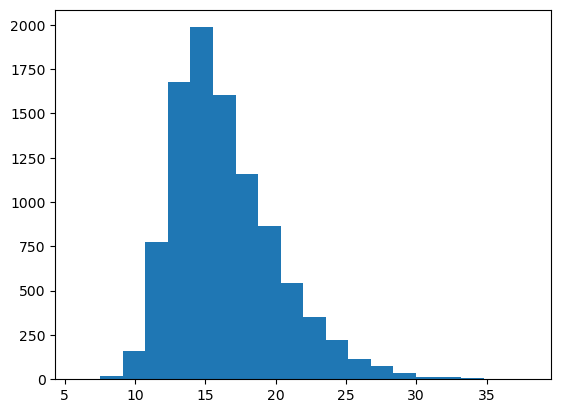

In [99]:
diff = test_cp_df['y_upper'] - test_cp_df['y_lower']

import matplotlib.pyplot as plt
plt.hist(diff, bins=20)
plt.show()

In [66]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_hat)
print(f"R2: {r2}")

y_lower_test, y_upper_test = reg.predict_quantiles(X_test)
coverage = cp.calc_coverage(y_lower_test, y_upper_test, y_test)
print(f"% in CI (CP): {np.mean(coverage)}") # IT WORKS!!

naive_CI = np.concatenate([y_lower_test[:, np.newaxis], y_upper_test[:, np.newaxis]], axis= 1)
greq_lb = y_test >= naive_CI[:, 0]
leq_up = y_test <= naive_CI[:, 1]
is_in_interval = greq_lb & leq_up
print(f"% in CI (Naive QR): {np.mean(is_in_interval)}") 

Range: 9.364980480814125 to 14.992566220224973: 0.9001029866117405
Range: 14.993457793168318 to 17.0721566932459: 0.8990731204943357
Range: 17.07337974138916 to 19.028260559330263: 0.9237899073120495
Range: 19.02985244442924 to 21.83212684552508: 0.9104016477857878
Range: 21.834030106624354 to 39.42399166733625: 0.9237113402061856


In [23]:
is_cond = X_test['Female'] == 0
y_lower_test_male = y_lower_test[is_cond.values]
y_upper_test_male = y_upper_test[is_cond.values]

naive_CI = np.concatenate([y_lower_test_male[:, np.newaxis], y_upper_test_male[:, np.newaxis]], axis= 1)
greq_lb = y_test[is_cond.values] >= naive_CI[:, 0]
leq_up = y_test[is_cond.values] <= naive_CI[:, 1]
is_in_interval = greq_lb & leq_up
print(f"% in CI (Naive QR): {np.mean(is_in_interval)}")

is_cond = X_test['Female'] == 1
y_lower_test_male = y_lower_test[is_cond.values]
y_upper_test_male = y_upper_test[is_cond.values]

naive_CI = np.concatenate([y_lower_test_male[:, np.newaxis], y_upper_test_male[:, np.newaxis]], axis= 1)
greq_lb = y_test[is_cond.values] >= naive_CI[:, 0]
leq_up = y_test[is_cond.values] <= naive_CI[:, 1]
is_in_interval = greq_lb & leq_up
print(f"% in CI (Naive QR): {np.mean(is_in_interval)}") 

% in CI (Naive QR): 0.9485523849198084
% in CI (Naive QR): 0.9502384408044785


In [67]:
from scipy import stats
print(stats.describe(cp_CI[:, 1] - cp_CI[:, 0]))
print(stats.describe(y))

Eth_Mex_Am: 0.9240348692403487
Eth_Oth_Hisp: 0.8993839835728953
Eth_Nonhisp_White: 0.9079563182527302
Eth_Nonhisp_Black: 0.90754039497307
Eth_Other: 0.9240986717267552


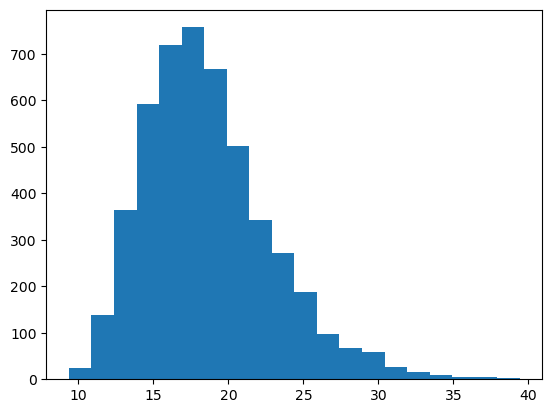

In [68]:
import matplotlib.pyplot as plt
plt.hist(y, bins=20)
plt.show()

In [69]:
import matplotlib.pyplot as plt
plt.scatter(list(predictions[0.05]), list(y['Waist']))
plt.show()

R2: 0.5581594395135963
R2: 0.5961280392695958
R2: 0.8925070590004979


In [58]:
list(y['Waist'])

['69.9',
 '74.3',
 '73.4',
 '89.4',
 '85.1',
 '68.5',
 '75.1',
 '74',
 '90.5',
 '87.2',
 '141',
 '75.7',
 '78.6',
 '85.7',
 '66.2',
 '72.6',
 '114.2',
 '91.2',
 '77.6',
 '106.6',
 '87.5',
 '85.2',
 '93.5',
 '74.1',
 '73',
 '108.6',
 '68.6',
 '85.1',
 '107.4',
 '93.7',
 '87.3',
 '86.6',
 '140.4',
 '93.3',
 '82',
 '84',
 '84.3',
 '77',
 '75.2',
 '67.5',
 '78.2',
 '78.3',
 '70.9',
 '141.8',
 '106.2',
 '109.7',
 '84.4',
 '90.5',
 '128.7',
 '112.4',
 '94.5',
 '134.3',
 '103.2',
 '138.2',
 '89.2',
 '89.7',
 '93.2',
 '78.5',
 '76',
 '109.9',
 '94.8',
 '89.5',
 '115.7',
 '112',
 '92.2',
 '86',
 '81.1',
 '88.7',
 '107.9',
 '79.2',
 '104.1',
 '113.8',
 '73.5',
 '120.3',
 '61.9',
 '124.9',
 '99',
 '99.4',
 '77.2',
 '141.4',
 '125.7',
 '105.5',
 '98.4',
 '117.7',
 '69.1',
 '89.9',
 '147',
 '79.9',
 '73.7',
 '88',
 '71.5',
 '71.4',
 '110.9',
 '126',
 '115.3',
 '114.2',
 '95.4',
 '100',
 '101.2',
 '82.5',
 '108.3',
 '105.1',
 '67.5',
 '89.3',
 '72',
 '92.2',
 '122.1',
 '70',
 '77.2',
 '103',
 '83.6'